In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
from datetime import datetime
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize
import matplotlib.tri as tri
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings

In [1]:
folder_path = "../"
file_name = "20221228T00.nc "

In [6]:
print(os.listdir('../'))

['.DS_Store', 'uv.lock', '20221228T00.nc', 'pyproject.toml', 'README.md', '.gitignore', 'sandbox', '.venv', '.python-version', 'environment.yaml', '.git', 'main.py', 'data', 'reports', 'src']


In [7]:
global_ds = xr.open_dataset(f"/Users/Julie/Desktop/wfrt_msc-thesis/20221228T00.nc", engine='netcdf4')
global_ds

<xarray.Dataset> Size: 147MB
Dimensions:    (values: 342916, time: 15)
Coordinates:
  * time       (time) datetime64[ns] 120B 2022-12-28 ... 2022-12-31T12:00:00
Dimensions without coordinates: values
Data variables:
    latitude   (values) float32 1MB ...
    longitude  (values) float32 1MB ...
    10u        (time, values) float32 21MB ...
    10v        (time, values) float32 21MB ...
    2t         (time, values) float32 21MB ...
    z_500      (time, values) float32 21MB ...
    z_850      (time, values) float32 21MB ...
    sp         (time, values) float32 21MB ...
    tp         (time, values) float32 21MB ...

In [9]:
global_ds.time

<xarray.DataArray 'time' (time: 15)> Size: 120B
array(['2022-12-28T00:00:00.000000000', '2022-12-28T06:00:00.000000000',
       '2022-12-28T12:00:00.000000000', '2022-12-28T18:00:00.000000000',
       '2022-12-29T00:00:00.000000000', '2022-12-29T06:00:00.000000000',
       '2022-12-29T12:00:00.000000000', '2022-12-29T18:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-30T06:00:00.000000000',
       '2022-12-30T12:00:00.000000000', '2022-12-30T18:00:00.000000000',
       '2022-12-31T00:00:00.000000000', '2022-12-31T06:00:00.000000000',
       '2022-12-31T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 120B 2022-12-28 ... 2022-12-31T12:00:00
Attributes:
    long_name:  time

In [8]:
date_range = pd.date_range(start='2023-01-01', end='2023-02-01')
print(date_range)

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
               '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
               '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24',
               '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28',
               '2023-01-29', '2023-01-30', '2023-01-31', '2023-02-01'],
              dtype='datetime64[ns]', freq='D')


In [2]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

In [5]:
global_ds = xr.open_dataset(f"/Users/Julie/Desktop/wfrt_msc-thesis/global_20221228T00.nc", engine='netcdf4')
bris_ds = xr.open_dataset(f"/Users/Julie/Desktop/wfrt_msc-thesis/bris_20221228T00.nc", engine='netcdf4')
climatex_ds = xr.open_dataset(f"/Users/Julie/Desktop/wfrt_msc-thesis/climatex_20221228T00.nc", engine='netcdf4')

In [6]:
def plot_basemap(ax):
    warnings.filterwarnings(
    "ignore",
    message="invalid value encountered in create_collection",
    category=RuntimeWarning,
    )

    ax.add_feature(cfeature.OCEAN, facecolor="#a6bddb", zorder=0)
    ax.add_feature(cfeature.LAND, facecolor="#D4DFED", zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5, zorder=2)

In [7]:
def get_norm(all_ds, initial_date, field, lead_times):
    vmins = []
    vmaxs = []

    for ds in all_ds:
        for lt in lead_times: 
            t = xtime(initial_date, lt)
            data = ds[field].sel(time=t).values
            vmins.append(np.min(data))
            vmaxs.append(np.max(data))

    vmin, vmax = np.nanmin(vmins), np.nanmax(vmaxs)
    norm = Normalize(vmin=vmin, vmax=vmax)

    return norm

In [8]:
def plot_data(ax, ds, field, time, norm, cbar_title):

    data = ds[field].sel(time=time).values

    geom = gpd.points_from_xy(ds.longitude, ds.latitude, crs=ccrs.PlateCarree())
    gdf = gpd.GeoDataFrame({'data': data}, geometry=geom)

    gdf.plot(
        ax=ax,
        column='data',
        markersize=10,
        cmap='coolwarm',
        legend=True,
        legend_kwds={"label": cbar_title, "shrink": 0.4},
        transform=ccrs.PlateCarree(),
        zorder=1,
        norm=norm,
        )


In [34]:
def plot_triangulation(fig, ax, ds, field, time, norm):

    # triangulation = tri.Triangulation(ds.longitude, ds.latitude)
    data = ds[field].sel(time=time).values
    print(np.count_nonzero(~np.isnan(data)))

    # contour=ax.tricontourf(triangulation, data, levels=20, cmap="coolwarm", norm=norm) #, transform=ccrs.PlateCarree())
    contour=ax.scatter(fix(ds.longitude), ds.latitude, data, cmap="coolwarm") #, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.4,)

In [10]:
def xtime(a, b):
    return datetime.strftime(
        a + pd.Timedelta(hours=int(b)), format="%Y-%m-%dT%H:00:00.000000000"
    )

In [11]:
def clip_global(global_coords, climatex_coords, tolerance=0.03):
    tree = cKDTree(climatex_coords)
    indices = tree.query_ball_point(global_coords, r=tolerance)
    mask = np.array([len(idx) > 0 for idx in indices])

    return mask

In [12]:
global_coords = np.column_stack((fix(global_ds.longitude.values), global_ds.latitude.values))
climatex_coords = np.column_stack((climatex_ds.longitude.values, climatex_ds.latitude.values))
mask = clip_global(global_coords, climatex_coords)

In [16]:
print(mask.sum())

3137


In [13]:
clipped_global_ds = global_ds.where(mask)
clipped_global_ds

<xarray.Dataset> Size: 80MB
Dimensions:    (values: 542080, time: 5)
Coordinates:
  * time       (time) datetime64[ns] 40B 2022-12-28 ... 2022-12-29
Dimensions without coordinates: values
Data variables:
    latitude   (values) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    longitude  (values) float32 2MB nan nan nan nan nan ... nan nan nan nan nan
    10u        (time, values) float32 11MB nan nan nan nan ... nan nan nan nan
    10v        (time, values) float32 11MB nan nan nan nan ... nan nan nan nan
    2t         (time, values) float32 11MB nan nan nan nan ... nan nan nan nan
    sp         (time, values) float32 11MB nan nan nan nan ... nan nan nan nan
    z_500      (time, values) float32 11MB nan nan nan nan ... nan nan nan nan
    z_850      (time, values) float32 11MB nan nan nan nan ... nan nan nan nan
    tp         (time, values) float32 11MB nan nan nan nan ... nan nan nan nan

In [17]:
clipped_global_ds.count()

<xarray.Dataset> Size: 72B
Dimensions:    ()
Data variables:
    latitude   int64 8B 3137
    longitude  int64 8B 3137
    10u        int64 8B 15685
    10v        int64 8B 15685
    2t         int64 8B 15685
    sp         int64 8B 15685
    z_500      int64 8B 15685
    z_850      int64 8B 15685
    tp         int64 8B 12548

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
plot_triangulation(fig, ax clipped_global_ds)

In [18]:
field = '2t'
cbar_title = {
    '2t': '2t [Kelvin]',
    '10u': '10u [m/s]',
    '10v': '10v [m/s]',
    'sp': 'sp [HPa]'
}
all_ds = [clipped_global_ds, bris_ds, climatex_ds]
models = ['global', 'bris', 'climatex']
lead_times = [0, 6, 12, 24]
initial_date = datetime(2022,12,28,0)
projection = ccrs.Stereographic(
    central_latitude=90.0,          # North Pole
    central_longitude=-90.0,        # STAND_LON
    true_scale_latitude=60.0        # Usually TRUELAT2 for polar stereo
)
norm = get_norm(all_ds, initial_date, field, lead_times)

0
1


/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)
/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


2
3


/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)
/Users/Julie/opt/anaconda3/envs/msc_venv/lib/python3.14/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


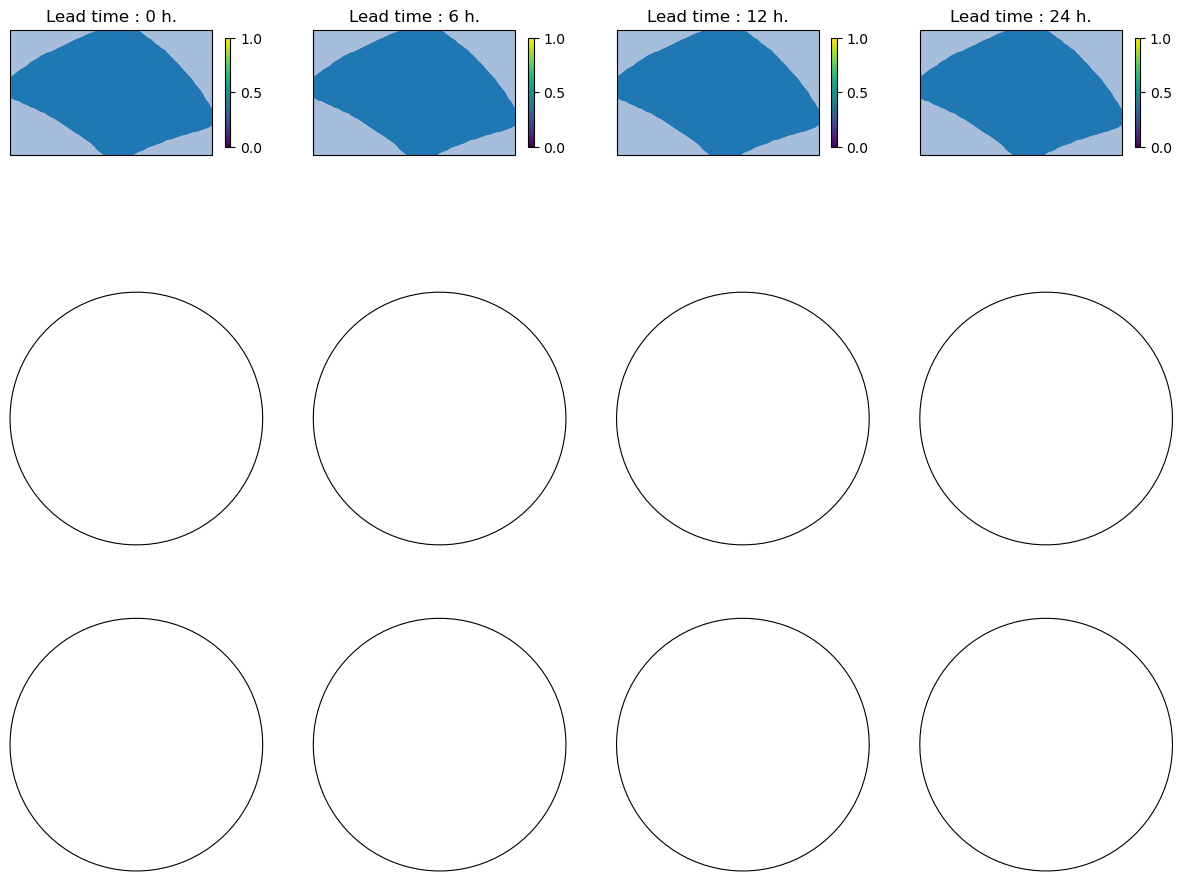

In [33]:
fig, ax = plt.subplots(len(all_ds),len(lead_times), figsize=(15,12), subplot_kw={'projection': projection})
ax = ax.ravel()

c = 0
m = 0
norm = get_norm(all_ds, initial_date, field, lead_times)
for ds in all_ds:
    for lt in lead_times: 
        print(c)
        t = xtime(initial_date, lt)
        colorbar_title = cbar_title.get(field)
        plot_basemap(ax[c])
        if c < len(lead_times):
            plot_triangulation(fig, ax[c], ds, field, t, norm)
        else:
            plot_data(ax[c], ds, field, t, norm, colorbar_title)

        if c < len(lead_times):
            ax[c].set_title(f"Lead time : {str(lt)} h.")
        if c % len(lead_times) == 0:
            ax[c].set_ylabel(f"{models[m]}")
            m+1
        if c > 3:
            break

        c += 1 
    if c > 3:
        break

# plt.savefig(f"../reports/plots/prediction/bris-climatex-{field}-20221228.png", dpi=200, bbox_inches='tight')
# plt.show()
    